In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy
import os
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import fsolve
import andreev_crystal as andreev_crystal
from scipy.interpolate import interp1d
from scipy.special import jv  # Bessel function J_l
from scipy.integrate import quad
from scipy.constants import hbar, e, k

# font = {"family" : "serif",
#           "serif" : ["Computer Modern Serif"],
#         'size'   : 11}

# plt.rc('font', **font)

#plt.style.use('seaborn') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif"  : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [2]:
def thermal_broadening(e_ax: np.ndarray, y: np.ndarray, T: float) -> np.ndarray:
    """
    Computes the thermal broadening of a given spectrum at a given temperature.

    Parameters:
    -----------
    e_ax : np.ndarray
        Array of energy axis values.
    y : np.ndarray
        Array of corresponding values.
    T : float
        Temperature at which to compute the thermal broadening.

    Returns:
    --------
    tb : np.ndarray
        Array of thermal broadening values.

    Raises:
    -------
    AssertionError:
        If the temperature is too low.
    """
    if T < 0.0007:
        print("Temperature too low for thermal broadening.")
        return y
    else:
        num_points = len(e_ax)
        
        y_f = interp1d(e_ax, y, bounds_error=False, fill_value="extrapolate")

        def integrand(x: np.ndarray, e: float, T: float) -> np.ndarray:
            return y_f(e - x * T) / (2 * (1 + np.cosh(x)))

        tb: np.ndarray = np.zeros_like(e_ax)

        for i, e in enumerate(e_ax):
            x = np.linspace(e_ax.min() / T, e_ax.max() / T, 4001)
            dx = x[1] - x[0]
            tb[i] = np.sum(integrand(x, e, T)) * dx

        return tb
    

# Function to characterize the band

# def characterize_band(Elst, G, threshold=1e-3):
#     max_G = np.max(np.abs(G))
#     if threshold != None:
#         mask = np.abs(G) >= threshold
#         if mask.sum() == 0:
#             return 0, 0, 0, -max_G, 0, 0
#         Elst = Elst[mask]
#         G = G[mask]
#     # Fit 2nd order polynomial
#     coefficients = np.polyfit(Elst, G, 2)
#     polynomial = np.poly1d(coefficients)
#     G_fit = polynomial(Elst)

#     max_G_fit = np.max(np.abs(G_fit))
#     idx = np.argwhere(G_fit <= -0.5*max_G_fit)
#     try:
#         FWHM_fit = Elst[np.max(idx)] - Elst[np.min(idx)]
#     except:
#         FWHM_fit = Elst[-1] - Elst[0]
#     variance = np.var(G)
#     mean = np.mean(G)
#     return FWHM_fit, variance, mean, -max_G_fit, Elst, G_fit

def plot_4by4(GLL, GLR, GRL, GRR, Energy_list,phi_list):
    vmin = -1#np.min(np.array([GLL,GLR,GRL,GRR]))
    vmax = 2#np.max(np.array([GLL,GLR,GRL,GRR]))

    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    #norm = mcolors.TwoSlopeNorm( vcenter=0)
    #norm = mcolors.CenteredNorm(vcenter=0, clip=False)

    fig_color, axs_c = plt.subplots(2,2, sharex=True, sharey=True, figsize=(3.4,3.2), layout='constrained')
    axs_c[0,0].pcolormesh(phi_list, Energy_list, GLL, cmap='bwr_r', norm= norm, shading='gouraud')
    axs_c[0,0].set_title(r'(a) $G_{LL}$', loc='left')
    axs_c[0,1].pcolormesh(phi_list, Energy_list, GLR, cmap='bwr_r', norm= norm, shading='gouraud')
    #axs_c[0,1].hlines(0.5,0,np.pi*4,'black')
    axs_c[0,1].set_title(r'(b) $G_{LR}$', loc='left')
    axs_c[1,0].pcolormesh(phi_list, Energy_list, GRL, cmap='bwr_r', norm= norm, shading='gouraud')
    axs_c[1,0].set_title(r'(c) $G_{RL}$', loc='left')
    pcm = axs_c[1,1].pcolormesh(phi_list, Energy_list, GRR, cmap='bwr_r', norm= norm, shading='gouraud')
    axs_c[1,1].set_title(r'(d) $G_{RR}$', loc='left');
    # axs_c[1,0].set(xlabel=r'$\phi$', xticks=[-2*np.pi, -np.pi, 0 , np.pi, 2*np.pi], xticklabels=[r'$-2\pi$', r'$-\pi$', '0', r'$\pi$', r'$2\pi$'])
    # axs_c[1,0].set(xlabel=r'$\phi$', xticks=[0, np.pi/2 , np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    axs_c[1,0].set(xlabel=r'$\phi$', xticks=[0, np.pi, 2*np.pi], xticklabels=[r'$0$', r'$\pi$', r'$2\pi$'])
    axs_c[1,1].set(xlabel=r'$\phi$')
    axs_c[0,0].set(ylabel=r'$\omega/\Delta$')
    axs_c[1,0].set(ylabel=r'$\omega/\Delta$')
    fig_color.colorbar(pcm, ax=axs_c, location='right', label=r'Conductance $[2e^2/h]$');

def plot_4by4_i(GLL, GLR, GRL, GRR, Energy_list, phi_list, two=False):

    vminL = 1#np.min(np.array([GLL,GLR,GRL,GRR]))
    vmaxL = 2#np.max(np.array([GLL,GLR,GRL,GRR]))

    normL = mcolors.TwoSlopeNorm(vmin=vminL, vcenter=vmaxL-(vmaxL-vminL)/2, vmax=vmaxL)

    vminNL = -1#np.min(np.array([GLL,GLR,GRL,GRR]))
    vmaxNL = 0.1#np.max(np.array([GLL,GLR,GRL,GRR]))

    normNL = mcolors.TwoSlopeNorm(vmin=vminNL, vcenter=vmaxNL-(vmaxNL-vminNL)/2, vmax=vmaxNL)

    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(7,1.8), layout='constrained')
    
    pcm1 = axs[0].pcolormesh(phi_list, Energy_list, GLL, cmap='Blues', shading='gouraud', norm=normL)
    fig.colorbar(pcm1, ax=axs[0], location='top', label=r'(a) $\quad$ $G_{LL}$ $[2e^2/h]$')
    # axs[0].set_title(r'(a) $G_{LL}$', loc='left')
    
    pcm2 = axs[1].pcolormesh(phi_list, Energy_list, GLR, cmap='Reds_r', shading='gouraud', norm=normNL)
    # axs[1].set_title(r'(b) $G_{LR}$', loc='left')
    axs[1].vlines(5*np.pi/4,np.min(Energy_list),np.max(Energy_list),'grey','dashed')
    fig.colorbar(pcm2, ax=axs[1], location='top', label=r'(b) $\quad $ $G_{LR}$ $[2e^2/h]$')
    
    pcm3 = axs[2].pcolormesh(phi_list, Energy_list, GRL, cmap='Reds_r', shading='gouraud', norm=normNL)
    # axs[2].set_title(r'(c) $G_{RL}$', loc='left')
    if two==True:
        axs[2].vlines(3*np.pi/4,np.min(Energy_list),np.max(Energy_list),'grey','dashed')
    fig.colorbar(pcm3, ax=axs[2], location='top', label=r'(c) $\quad$ $G_{RL}$ $[2e^2/h]$')
    
    pcm4 = axs[3].pcolormesh(phi_list, Energy_list, GRR, cmap='Blues', shading='gouraud', norm=normL)
    # axs[3].set_title(r'(d) $G_{RR}$', loc='left')
    fig.colorbar(pcm4, ax=axs[3], location='top', label=r'(d) $\quad$ $G_{RR}$ $[2e^2/h]$')
    
    axs[0].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'], ylabel=r'$\omega/\Delta$')
    axs[1].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    axs[2].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    axs[3].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

def plot_2by4_i(GLLt, GLRt, GRLt, GRRt, Energy_listt, phi_listt,GLLb, GLRb, GRLb, GRRb, Energy_listb, phi_listb,phase,E_lst_resonance):
    vminL = 1#np.min(np.array([GLL,GLR,GRL,GRR]))
    vmaxL = 2#np.max(np.array([GLL,GLR,GRL,GRR]))

    normL = mcolors.TwoSlopeNorm(vmin=vminL, vcenter=1.5, vmax=vmaxL)

    vminNL = -1#np.min(np.array([GLL,GLR,GRL,GRR]))
    vmaxNL = 0#np.max(np.array([GLL,GLR,GRL,GRR]))

    normNL = mcolors.TwoSlopeNorm(vmin=vminNL, vcenter=-0.5, vmax=vmaxNL)


    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(7,3.6), layout='constrained')
    
    pcm00 = axs[0,0].pcolormesh(phi_listt, Energy_listt, GLLt, cmap='Blues', shading='gouraud', norm=normL, rasterized=True)
    cb00 = fig.colorbar(pcm00, ax=axs[0,0], location='top')#, label=r'(a) $\quad$ $G_{LL}$ $[2e^2/h]$')
    # axs[0].set_title(r'(a) $G_{LL}$', loc='left')
    cb00.set_label(r'(a) $\quad$ $G_{LL}$ $(2e^2/h)$', loc='left')
    
    pcm11 = axs[0,1].pcolormesh(phi_listt, Energy_listt, GRLt, cmap='Reds_r', shading='gouraud', norm=normNL, rasterized=True)
    # axs[1].set_title(r'(b) $G_{LR}$', loc='left')
    cb01 = fig.colorbar(pcm11, ax=axs[0,1], location='top')#, label=r'(b) $\quad $ $G_{LR}$ $[2e^2/h]$')
    cb01.set_label(r'(b) $\quad $ $G_{RL}$ $(2e^2/h)$', loc='left')
    
    pcm02 = axs[0,2].pcolormesh(phi_listt, Energy_listt, GLRt, cmap='Reds_r', shading='gouraud', norm=normNL, rasterized=True)
    # axs[2].set_title(r'(c) $G_{RL}$', loc='left')
    axs[0,2].plot(phase,E_lst_resonance, 'k', linewidth=.8, linestyle='dashed')
    cb02 = fig.colorbar(pcm02, ax=axs[0,2], location='top', label=r'(c) $\quad$ $G_{LR}$ $(2e^2/h)$')
    cb02.set_label(r'(c) $\quad$ $G_{LR}$ $(2e^2/h)$', loc='left')
    
    pcm03 = axs[0,3].pcolormesh(phi_listt, Energy_listt, GRRt, cmap='Blues', shading='gouraud', norm=normL, rasterized=True)
    # axs[3].set_title(r'(d) $G_{RR}$', loc='left')
    cb03 = fig.colorbar(pcm03, ax=axs[0,3], location='top', label=r'(d) $\quad$ $G_{RR}$ $(2e^2/h)$')
    cb03.set_label(r'(d) $\quad$ $G_{RR}$ $(2e^2/h)$', loc='left')

    pcm1 = axs[1,0].pcolormesh(phi_listb, Energy_listb, GLLb, cmap='Blues', shading='gouraud', norm=normL, rasterized=True)
    cb10 = fig.colorbar(pcm1, ax=axs[1,0], location='top')#, label=r'(a) $\quad$ $G_{LL}$ $[2e^2/h]$')
    # axs[0].set_title(r'(a) $G_{LL}$', loc='left')
    cb10.set_label(r'(e) $\quad$ $G_{LL}$ $(2e^2/h)$', loc='left')

    pcm2 = axs[1,1].pcolormesh(phi_listb, Energy_listb, GRLb, cmap='Reds_r', shading='gouraud', norm=normNL, rasterized=True)
    # axs[1].set_title(r'(b) $G_{LR}$', loc='left')
    axs[1,2].vlines(5*np.pi/4,-1,1,'grey','dashed')
    cb11 = fig.colorbar(pcm2, ax=axs[1,1], location='top')#, label=r'(b) $\quad $ $G_{LR}$ $[2e^2/h]$')
    cb11.set_label(r'(f) $\quad $ $G_{RL}$ $(2e^2/h)$', loc='left')
    
    pcm3 = axs[1,2].pcolormesh(phi_listb, Energy_listb, GLRb, cmap='Reds_r', shading='gouraud', norm=normNL, rasterized=True)
    # axs[2].set_title(r'(c) $G_{RL}$', loc='left')
    axs[1,1].vlines(5*np.pi/4,-1,1,'grey','dashed')
    cb12 = fig.colorbar(pcm3, ax=axs[1,2], location='top')#, label=r'(c) $\quad$ $G_{RL}$ $[2e^2/h]$')
    cb12.set_label(r'(g) $\quad$ $G_{LR}$ $(2e^2/h)$', loc='left')
    
    pcm4 = axs[1,3].pcolormesh(phi_listb, Energy_listb, GRRb, cmap='Blues', shading='gouraud', norm=normL, rasterized=True)
    # axs[3].set_title(r'(d) $G_{RR}$', loc='left')
    cb13 = fig.colorbar(pcm4, ax=axs[1,3], location='top')#, label=r'(d) $\quad$ $G_{RR}$ $[2e^2/h]$')
    cb13.set_label(r'(h) $\quad$ $G_{RR}$ $(2e^2/h)$', loc='left')

    axs[0,0].set(ylabel=r'$eV $ $(\Delta)$')
    
    axs[1,0].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'], ylabel=r'$eV $ $(\Delta)$')
    axs[1,1].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    axs[1,2].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    axs[1,3].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

In [3]:
# Function to characterize the band

def characterize_band(Elst, G, threshold=1e-3):
    max_G = np.max(np.abs(G))
    if threshold != None:
        mask = np.abs(G) >= threshold
        if mask.sum() == 0:
            return 0, 0, 0, -max_G, 0, 0
        Elst = Elst[mask]
        G = G[mask]
    # Fit 2nd order polynomial
    coefficients = np.polyfit(Elst, G, 2)
    polynomial = np.poly1d(coefficients)
    G_fit = polynomial(Elst)

    ### Fit to gaussian instead of polynomial
    # def gaussian(x, a, b, c):
    #     return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    # from scipy.optimize import curve_fit
    # popt, _ = curve_fit(gaussian, Elst, G, p
    # G_fit = gaussian(Elst, *popt)
    ### End of gaussian fit

    max_G_fit = np.max(np.abs(G_fit))
    # idx = np.argwhere(G_fit <= -0.5*max_G_fit)
    idx = np.argwhere(G_fit <= -0.5*max_G)
    variance = np.var(G)
    mean = np.mean(G)
    FWHM_fit = Elst[-1] - Elst[0]
    try:
        FWHM_fit = Elst[np.max(idx)] - Elst[np.min(idx)]
        #print("FWHM fit successful.", np.max(idx), np.min(idx), Elst[np.max(idx)], Elst[np.min(idx)])
    except:
        FWHM_fit = Elst[-1] - Elst[0]
        print("FWHM fit failed, using full range instead.")
    return FWHM_fit, variance, mean, -max_G_fit, Elst, G_fit, max_G

In [4]:
num = 200
num_energy = 2000
Energy_list_n2 = np.linspace(-1.01,1.01,num_energy)
Energy_list_n21 = np.linspace(-1.01,1.01,num_energy)
phi_list = np.linspace(0, 2*np.pi, num)
nummer = np.argwhere(Energy_list_n21>-1.01)[0][0]
l_S = 0.7
gamma = 3
T = 1
E_F = 6#6
Temp = 30*1e-3

l_250 = 250 * 1e-9
l_500 = 500 * 1e-9


n2 = 2
n21 = 21

phi = 5*np.pi/4

In [5]:
GLLn2, GLRn2, GRLn2, GRRn2 = andreev_crystal.G(Energy_list_n2, num_energy, phi_list, num, n2, l_S, gamma, T, E_F)

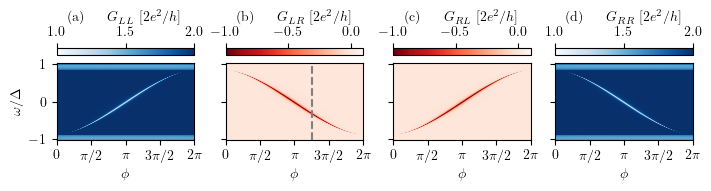

In [6]:
plot_4by4_i(GLLn2, GLRn2, GRLn2, GRRn2, Energy_list_n2, phi_list)

In [7]:
def energy_phase(energy):
    return 2*np.arccos(energy)

In [8]:
phase = []
E_lst_resonance = np.linspace(-0.94, 0.94, 1000)
for E in E_lst_resonance:
    w = E * ( 1 + np.sqrt(1-E**2+0j)/gamma )
    #w = E
    phase.append(energy_phase(w))
phase = np.array(phase)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


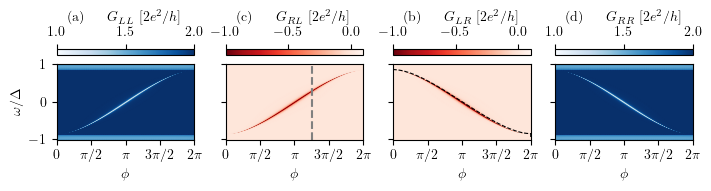

In [9]:
vminL = 1#np.min(np.array([GLL,GLR,GRL,GRR]))
vmaxL = 2#np.max(np.array([GLL,GLR,GRL,GRR]))

normL = mcolors.TwoSlopeNorm(vmin=vminL, vcenter=vmaxL-(vmaxL-vminL)/2, vmax=vmaxL)

vminNL = -1#np.min(np.array([GLL,GLR,GRL,GRR]))
vmaxNL = 0.1#np.max(np.array([GLL,GLR,GRL,GRR]))

normNL = mcolors.TwoSlopeNorm(vmin=vminNL, vcenter=vmaxNL-(vmaxNL-vminNL)/2, vmax=vmaxNL)

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(7,1.8), layout='constrained')

pcm1 = axs[0].pcolormesh(phi_list, Energy_list_n2, GLLn2, cmap='Blues', shading='gouraud', norm=normL)
fig.colorbar(pcm1, ax=axs[0], location='top', label=r'(a) $\quad$ $G_{LL}$ $[2e^2/h]$')
# axs[0].set_title(r'(a) $G_{LL}$', loc='left')

pcm2 = axs[2].pcolormesh(phi_list, Energy_list_n2, GLRn2, cmap='Reds_r', shading='gouraud', norm=normNL)
# axs[1].set_title(r'(b) $G_{LR}$', loc='left')
axs[1].vlines(5*np.pi/4,np.min(Energy_list_n2),np.max(Energy_list_n2),'grey','dashed')
fig.colorbar(pcm2, ax=axs[2], location='top', label=r'(b) $\quad $ $G_{LR}$ $[2e^2/h]$')

pcm3 = axs[1].pcolormesh(phi_list, Energy_list_n2, GRLn2, cmap='Reds_r', shading='gouraud', norm=normNL)
# axs[2].set_title(r'(c) $G_{RL}$', loc='left')
#if two==True:
#axs[2].vlines(3*np.pi/4,np.min(Energy_list_n2),np.max(Energy_list_n2),'grey','dashed')
axs[2].plot(phase,E_lst_resonance, 'k', linewidth=.8, linestyle='dashed')
fig.colorbar(pcm3, ax=axs[1], location='top', label=r'(c) $\quad$ $G_{RL}$ $[2e^2/h]$')

pcm4 = axs[3].pcolormesh(phi_list, Energy_list_n2, GRRn2, cmap='Blues', shading='gouraud', norm=normL)
# axs[3].set_title(r'(d) $G_{RR}$', loc='left')
fig.colorbar(pcm4, ax=axs[3], location='top', label=r'(d) $\quad$ $G_{RR}$ $[2e^2/h]$')

axs[0].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'], ylabel=r'$\omega/\Delta$')
axs[1].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs[2].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs[3].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.show()

In [10]:
GLLn21, GLRn21, GRLn21, GRRn21 = andreev_crystal.G(Energy_list_n21, num_energy, phi_list, num, n21, l_S, gamma, T, E_F)

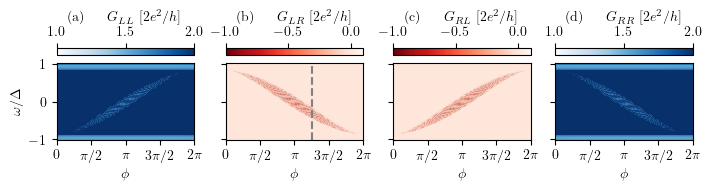

In [11]:
plot_4by4_i(GLLn21[nummer:,:], GLRn21[nummer:,:], GRLn21[nummer:,:], GRRn21[nummer:,:], Energy_list_n21[nummer:], phi_list)

In [12]:
GLLn21_tb = np.zeros_like(GLLn21)
GLRn21_tb = np.zeros_like(GLRn21)
GRLn21_tb = np.zeros_like(GRLn21)
GRRn21_tb = np.zeros_like(GRRn21)

GLLn2_tb = np.zeros_like(GLLn2)
GLRn2_tb = np.zeros_like(GLRn2)
GRLn2_tb = np.zeros_like(GRLn2)
GRRn2_tb = np.zeros_like(GRRn2)

for i in range(num):
    GLLn21_tb[:,i] = thermal_broadening(Energy_list_n21, GLLn21[:,i], Temp)
    GLRn21_tb[:,i] = thermal_broadening(Energy_list_n21, GLRn21[:,i], Temp)
    GRLn21_tb[:,i] = thermal_broadening(Energy_list_n21, GRLn21[:,i], Temp)
    GRRn21_tb[:,i] = thermal_broadening(Energy_list_n21, GRRn21[:,i], Temp)

    GLLn2_tb[:,i] = thermal_broadening(Energy_list_n2, GLLn2[:,i], Temp)
    GLRn2_tb[:,i] = thermal_broadening(Energy_list_n2, GLRn2[:,i], Temp)
    GRLn2_tb[:,i] = thermal_broadening(Energy_list_n2, GRLn2[:,i], Temp)
    GRRn2_tb[:,i] = thermal_broadening(Energy_list_n2, GRRn2[:,i], Temp)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


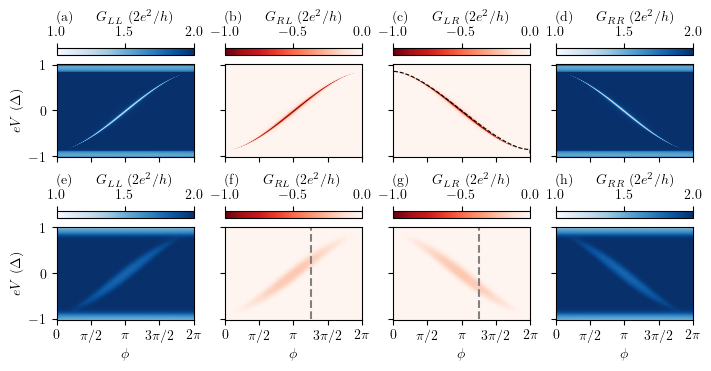

In [13]:
plot_2by4_i(GLLn2, GLRn2, GRLn2, GRRn2, Energy_list_n2, phi_list,GLLn21_tb[nummer:,:], GLRn21_tb[nummer:,:], GRLn21_tb[nummer:,:], GRRn21_tb[nummer:,:], Energy_list_n21[nummer:], phi_list, phase, E_lst_resonance)
plt.savefig('GLR2x4_tb.pdf', bbox_inches='tight', dpi=300, pad_inches=0.0)

Generate Fig. 2

In [14]:
len_Super_lst = np.linspace(0, 2,1000)#, 100)
Rhe_lst_zeroE = np.zeros_like(len_Super_lst)
Tee_lst_zeroE = np.zeros_like(len_Super_lst)
Rhe_lst_05E = np.zeros_like(len_Super_lst)
Tee_lst_05E = np.zeros_like(len_Super_lst)
Rhe_lst_09E = np.zeros_like(len_Super_lst)
Tee_lst_09E = np.zeros_like(len_Super_lst)
Rhe_lst_099E = np.zeros_like(len_Super_lst)
Tee_lst_099E = np.zeros_like(len_Super_lst)

In [15]:
for i, length_super in enumerate(len_Super_lst):
    S = andreev_crystal.S_AC(0, 0, 1, length_super, gamma, T, E_F)
    Rhe_lst_zeroE[i] = np.abs(S[1,0])**2
    Tee_lst_zeroE[i] = np.abs(S[2,0])**2
    S05 = andreev_crystal.S_AC(0.5, 0, 1, length_super, gamma, T, E_F)
    Rhe_lst_05E[i] = np.abs(S05[1,0])**2
    Tee_lst_05E[i] = np.abs(S05[2,0])**2
    S09 = andreev_crystal.S_AC(0.9, 0, 1, length_super, gamma, T, E_F)
    Rhe_lst_09E[i] = np.abs(S09[1,0])**2
    Tee_lst_09E[i] = np.abs(S09[2,0])**2
    S099 = andreev_crystal.S_AC(0.99, 0, 1, length_super, gamma, T, E_F)
    Rhe_lst_099E[i] = np.abs(S099[1,0])**2
    Tee_lst_099E[i] = np.abs(S099[2,0])**2



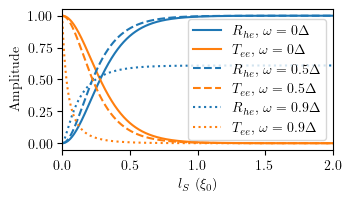

In [16]:
plt.figure(figsize=(3.4, 1.9), layout='constrained')
plt.plot(len_Super_lst, Rhe_lst_zeroE, label=r'$R_{he}$, $\omega=0\Delta$')
plt.plot(len_Super_lst, Tee_lst_zeroE, label=r'$T_{ee}$, $\omega=0\Delta$')
plt.plot(len_Super_lst, Rhe_lst_05E, 'tab:blue', linestyle='dashed', label=r'$R_{he}$, $\omega=0.5\Delta$')
plt.plot(len_Super_lst, Tee_lst_05E, 'tab:orange', linestyle='dashed', label=r'$T_{ee}$, $\omega=0.5\Delta$')
plt.plot(len_Super_lst, Rhe_lst_09E, 'tab:blue', linestyle='dotted', label=r'$R_{he}$, $\omega=0.9\Delta$')
plt.plot(len_Super_lst, Tee_lst_09E, 'tab:orange', linestyle='dotted', label=r'$T_{ee}$, $\omega=0.9\Delta$')

plt.xlabel(r'$l_{S}$ $(\xi_0)$')
plt.ylabel('Amplitude')#(r'$R_{he},$ $ T_{ee}$')
plt.xlim(0, 2)
plt.legend()
plt.savefig('Rhe_Tee_vs_length.pdf', bbox_inches='tight', dpi=300, pad_inches=0.0)

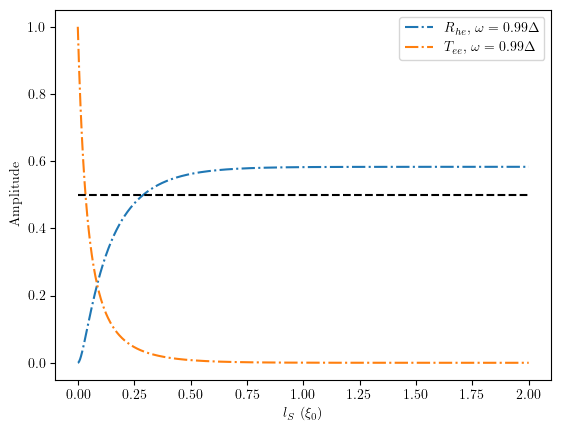

In [17]:
plt.plot(len_Super_lst, Rhe_lst_099E, 'tab:blue', linestyle='dashdot', label=r'$R_{he}$, $\omega=0.99\Delta$')
plt.plot(len_Super_lst, Tee_lst_099E, 'tab:orange', linestyle='dashdot', label=r'$T_{ee}$, $\omega=0.99\Delta$')
plt.hlines(0.5, 0, 2, 'black', linestyle='dashed')
plt.xlabel(r'$l_{S}$ $(\xi_0)$')
plt.ylabel('Amplitude')#(r'$R_{he},$ $ T_{ee}$')
plt.legend()

In [18]:
GLL_n21_1d_500, GLR_n21_1d_500, GRL_n21_1d_500, GRR_n21_1d_500 = andreev_crystal.G_1d(Energy_list_n21, phi, num_energy, n21, l_S, gamma, T, E_F)#, L_S1=l_500, L_Sn=l_500)
GLL_n21_1d_250, GLR_n21_1d_250, GRL_n21_1d_250, GRR_n21_1d_250 = andreev_crystal.G_1d(Energy_list_n21, phi, num_energy, n21, l_S, gamma, T, E_F)#, L_S1=l_250, L_Sn=l_250)
tb_GLR_30mK_1d_500 = thermal_broadening(Energy_list_n21, GLR_n21_1d_500, Temp)
tb_GLR_30mK_1d_250 = thermal_broadening(Energy_list_n21, GLR_n21_1d_250, Temp)
tb_GRL_30mK_1d_500 = thermal_broadening(Energy_list_n21, GRL_n21_1d_500, Temp)
tb_GRL_30mK_1d_250 = thermal_broadening(Energy_list_n21, GRL_n21_1d_250, Temp)


In [19]:
l_S_test = 0.5 #500*1e-9

GLL_n21_1d_test, GLR_n21_1d_test, GRL_n21_1d_test, GRR_n21_1d_test = andreev_crystal.G_1d(Energy_list_n21, phi, num_energy, 21, l_S_test, gamma, T, E_F, L_S1=l_S_test/2, L_Sn=l_S_test/2)
tb_GLR_30mK_1d_test = thermal_broadening(Energy_list_n21, GLR_n21_1d_test, Temp)
tb_GRL_30mK_1d_test = thermal_broadening(Energy_list_n21, GRL_n21_1d_test, Temp)

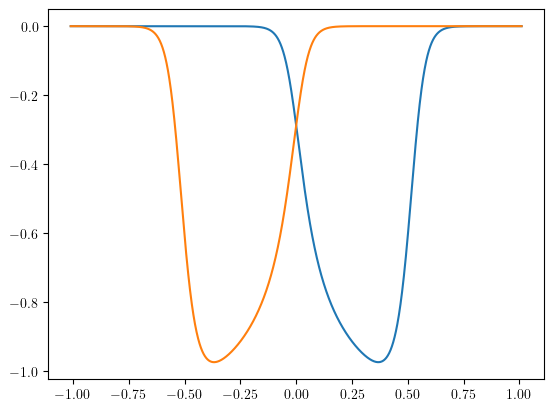

In [20]:
plt.plot(Energy_list_n21, tb_GRL_30mK_1d_test, label=r'$L_S=200$ nm, GRL')
plt.plot(Energy_list_n21, tb_GLR_30mK_1d_test, label=r'$L_S=200$ nm, GLR')

In [21]:
l_lst = np.linspace(0.1,1.5,100)

max_GLR_tb = np.zeros_like(l_lst)
max_GRL_tb = np.zeros_like(l_lst)

for i, l in enumerate(l_lst):
    GLL_n21_1d, GLR_n21_1d, GRL_n21_1d, GRR_n21_1d = andreev_crystal.G_1d(Energy_list_n21, phi, num_energy, n21, l_S, gamma, T, E_F, L_S1=l*l_S, L_Sn=l*l_S)
    tb_GLR_30mK_1d = thermal_broadening(Energy_list_n21, GLR_n21_1d, Temp)
    tb_GRL_30mK_1d = thermal_broadening(Energy_list_n21, GRL_n21_1d, Temp)
    max_GLR_tb[i] = np.max(np.abs(tb_GLR_30mK_1d[nummer:]))
    max_GRL_tb[i] = np.max(np.abs(tb_GRL_30mK_1d[nummer:]))


In [22]:
# Find FWHM, variance, mean and max_G for n=21 and l_S from 100 nm to 1000 nm
num_ch = 500*4
En_list = np.linspace(-1.01,1.01,num_ch)
nummer_ch = np.argwhere(En_list>-1.01)[0][0]
n_ch = 21

bw_ls_list = []
mu_ls_list = []
var_ls_list = []
mG_ls_list = []
mG_ls_nfit_list = []
bw_ls_list_tb = []
mu_ls_list_tb = []
var_ls_list_tb = []
mG_ls_list_tb = []
mG_ls_nfit_list_tb = []
threshold=3*1e-2

l_S_lst = np.linspace(0.05, 2,101)#, 100)

for L_S in l_S_lst:
    l_S_half = L_S/2
    GLLn, GLRn, GRLn, GRRn = andreev_crystal.G_1d(En_list, phi, num_ch, n_ch, L_S, gamma, T, E_F, L_S1=l_S_half, L_Sn=l_S_half)
    tb_GRLn = thermal_broadening(En_list, GRLn, Temp)
    print(f'Processing l_S/xi_0 = {L_S:.3f}.')
    FWHM_tb, var_tb, mu_tb, mG_tb, Elst_tb, G_FIT_tb, mG_nfit_tb = characterize_band(En_list[nummer_ch:], tb_GRLn[nummer_ch:], threshold=threshold)
    #FWHM, var, mu, mG, Elst, G_FIT, mG_nfit = characterize_band(En_list[nummer_ch:], GLRn[nummer_ch:], threshold=threshold)
    # bw_ls_list.append(FWHM)
    # mu_ls_list.append(mu)
    # var_ls_list.append(var)
    # mG_ls_list.append(mG)
    # mG_ls_nfit_list.append(mG_nfit)
    bw_ls_list_tb.append(FWHM_tb)
    mu_ls_list_tb.append(mu_tb)
    var_ls_list_tb.append(var_tb)
    mG_ls_list_tb.append(mG_tb)
    mG_ls_nfit_list_tb.append(mG_nfit_tb)
    

Processing l_S/xi_0 = 0.050.
Processing l_S/xi_0 = 0.070.
Processing l_S/xi_0 = 0.089.
Processing l_S/xi_0 = 0.108.
Processing l_S/xi_0 = 0.128.
Processing l_S/xi_0 = 0.148.
Processing l_S/xi_0 = 0.167.
Processing l_S/xi_0 = 0.186.
Processing l_S/xi_0 = 0.206.
Processing l_S/xi_0 = 0.225.
Processing l_S/xi_0 = 0.245.
Processing l_S/xi_0 = 0.265.
Processing l_S/xi_0 = 0.284.
Processing l_S/xi_0 = 0.303.
Processing l_S/xi_0 = 0.323.
Processing l_S/xi_0 = 0.342.
Processing l_S/xi_0 = 0.362.
Processing l_S/xi_0 = 0.382.
Processing l_S/xi_0 = 0.401.
Processing l_S/xi_0 = 0.420.
Processing l_S/xi_0 = 0.440.
Processing l_S/xi_0 = 0.459.
Processing l_S/xi_0 = 0.479.
Processing l_S/xi_0 = 0.498.
Processing l_S/xi_0 = 0.518.
Processing l_S/xi_0 = 0.537.
Processing l_S/xi_0 = 0.557.
Processing l_S/xi_0 = 0.577.
Processing l_S/xi_0 = 0.596.
Processing l_S/xi_0 = 0.616.
Processing l_S/xi_0 = 0.635.
Processing l_S/xi_0 = 0.655.
Processing l_S/xi_0 = 0.674.
Processing l_S/xi_0 = 0.694.
Processing l_S

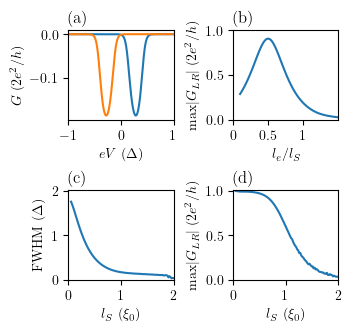

In [34]:
nummer = np.argwhere(Energy_list_n21>-1.01)[0][0]
fig, axs = plt.subplots(2, 2, figsize=(3.4,3.2), layout='constrained')
axs[0,0].plot(Energy_list_n21[nummer:], tb_GRL_30mK_1d_500[nummer:], 'tab:blue', linestyle='-', label=r'$G_{RL}$')# label=r'$l_{1n} = 300$ nm')
axs[0,0].plot(Energy_list_n21[nummer:], tb_GLR_30mK_1d_500[nummer:], 'tab:orange',label=r'$G_{LR}$')# label=r'$l_{1n} = 500$ nm')
axs[0,0].set(xlabel=r'$eV$ $(\Delta)$', ylabel=r'$G$ $(2e^2/h)$')
axs[0,0].set_xlim(-1,1)
#axs[0,0].legend()
axs[0,0].set_title(r'(a)', loc='left')

axs[0,1].plot(l_lst, max_GRL_tb, label=r'$G_{RL}$')
#axs[0,1].plot(l_lst, max_GLR_tb, label=r'$G_{LR}$')
#axs[0,1].vlines(500, 0, 1, 'grey', 'dashed')
axs[0,1].set(xlabel=r'$l_e/l_S$', ylabel=r'max$|G_{LR}|$ $(2e^2/h)$')
axs[0,1].set_xlim(0,1.5)
axs[0,1].set_ylim(0, 1)
axs[0,1].set_xticks([0, 0.5, 1])
axs[0,1].set_xticklabels([r'$0$', r'$0.5$', r'$1$'])
#axs[0,1].legend()
axs[0,1].set_title(r'(b)', loc='left')

axs[1,0].plot(l_S_lst, bw_ls_list_tb)
axs[1,0].set(xlabel=r'$l_S$ $(\xi_0)$', ylabel=r'FWHM $(\Delta)$')
axs[1,0].set_ylim(0,2.01)
axs[1,0].set_xlim(0, 2)
axs[1,0].set_title(r'(c)', loc='left')

axs[1,1].plot(l_S_lst, mG_ls_nfit_list_tb)
axs[1,1].set(xlabel=r'$l_S$ $(\xi_0)$', ylabel=r'max$|G_{LR}|$ $(2e^2/h)$')
axs[1,1].set_xlim(0,2)
axs[1,1].set_ylim(0, 1.01)
axs[1,1].set_title(r'(d)', loc='left')

plt.savefig('GLR_1d_charachterized.pdf', bbox_inches='tight', dpi=300, pad_inches=0.0)
plt.show()

In [24]:
T = 0.8
Energy_list_n21_T85 = np.linspace(-1.01,1.01,num_energy)
nummer_T85 = np.argwhere(Energy_list_n21_T85>-1.01)[0][0]
GLLn21_T8, GLRn21_T8, GRLn21_T8, GRRn21_T8 = andreev_crystal.G(Energy_list_n21_T85, num_energy, phi_list, num, n21, l_S, gamma, T, E_F, L_S1=l_S/2, L_Sn=l_S/2)

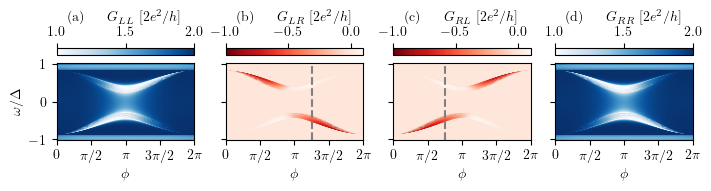

In [25]:
plot_4by4_i(GLLn21_T8[nummer_T85:,:], GLRn21_T8[nummer_T85:,:], GRLn21_T8[nummer_T85:,:], GRRn21_T8[nummer_T85:,:], Energy_list_n21_T85[nummer_T85:], phi_list, two=True)

In [26]:
GLLn21_T8_tb = np.zeros_like(GLLn21_T8)
GLRn21_T8_tb = np.zeros_like(GLRn21_T8)
GRLn21_T8_tb = np.zeros_like(GRLn21_T8)
GRRn21_T8_tb = np.zeros_like(GRRn21_T8)

for i in range(num):
    GLLn21_T8_tb[:,i] = thermal_broadening(Energy_list_n21_T85, GLLn21_T8[:,i], Temp)
    GLRn21_T8_tb[:,i] = thermal_broadening(Energy_list_n21_T85, GLRn21_T8[:,i], Temp)
    GRLn21_T8_tb[:,i] = thermal_broadening(Energy_list_n21_T85, GRLn21_T8[:,i], Temp)
    GRRn21_T8_tb[:,i] = thermal_broadening(Energy_list_n21_T85, GRRn21_T8[:,i], Temp)

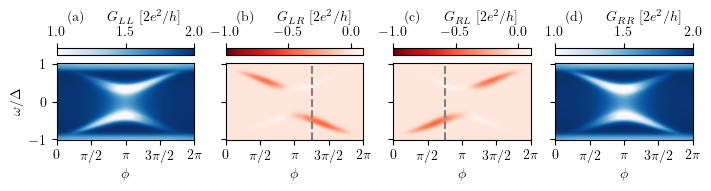

In [27]:
plot_4by4_i(GLLn21_T8_tb[nummer_T85:,:], GLRn21_T8_tb[nummer_T85:,:], GRLn21_T8_tb[nummer_T85:,:], GRRn21_T8_tb[nummer_T85:,:], Energy_list_n21_T85[nummer_T85:], phi_list, two=True)

In [28]:
T_lst = np.linspace(0,1,100)
max_GLR_tb_T = np.zeros_like(T_lst)
max_GRL_tb_T = np.zeros_like(T_lst)

for i, T in enumerate(T_lst):
    GLL_n21_1d_T, GLR_n21_1d_T, GRL_n21_1d_T, GRR_n21_1d_T = andreev_crystal.G_1d(Energy_list_n21, phi, num_energy, n21, l_S, gamma, T, E_F, L_S1=l_S/2, L_Sn=l_S/2)
    tb_GLR_30mK_1d_T = thermal_broadening(Energy_list_n21, GLR_n21_1d_T, Temp)
    tb_GRL_30mK_1d_T = thermal_broadening(Energy_list_n21, GRL_n21_1d_T, Temp)
    max_GLR_tb_T[i] = np.max(np.abs(tb_GLR_30mK_1d_T[nummer:]))
    max_GRL_tb_T[i] = np.max(np.abs(tb_GRL_30mK_1d_T[nummer:]))

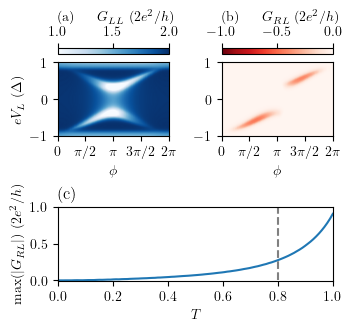

In [32]:
#T_lst = np.linspace(0,1,100)

vminL = 1#np.min(np.array([GLL,GLR,GRL,GRR]))
vmaxL = 2#np.max(np.array([GLL,GLR,GRL,GRR]))

normL = mcolors.TwoSlopeNorm(vmin=vminL, vcenter=1.5, vmax=vmaxL)

vminNL = -1#np.min(np.array([GLL,GLR,GRL,GRR]))
vmaxNL = 0#np.max(np.array([GLL,GLR,GRL,GRR]))

normNL = mcolors.TwoSlopeNorm(vmin=vminNL, vcenter=-0.5, vmax=vmaxNL)


fig, axs = plt.subplot_mosaic([['A', 'B'], ['C', 'C']], figsize=(3.4,3.2), layout='constrained')

pcm00 = axs["A"].pcolormesh(phi_list, Energy_list_n21_T85[nummer_T85:], GLLn21_T8_tb[nummer_T85:,:], cmap='Blues', shading='gouraud', norm=normL, rasterized=True)
cb00 = fig.colorbar(pcm00, ax=axs["A"], location='top')#, label=r'(a) $\quad$ $G_{LL}$ $[2e^2/h]$')
# axs[0].set_title(r'(a) $G_{LL}$', loc='left')
cb00.set_label(r'(a) $\quad$ $G_{LL}$ $(2e^2/h)$', loc='left')

pcm11 = axs["B"].pcolormesh(phi_list, Energy_list_n21_T85[nummer_T85:], GRLn21_T8_tb[nummer_T85:,:], cmap='Reds_r', shading='gouraud', norm=normNL, rasterized=True)
# axs[1].set_title(r'(b) $G_{LR}$', loc='left')
cb01 = fig.colorbar(pcm11, ax=axs["B"], location='top')#, label=r'(b) $\quad $ $G_{LR}$ $[2e^2/h]$')
cb01.set_label(r'(b) $\quad $ $G_{RL}$ $(2e^2/h)$', loc='left')

axs["A"].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'], ylabel=r'$eV_L$ $(\Delta)$')
axs["B"].set(xlabel=r'$\phi$', xticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], xticklabels=[r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

axs["C"].plot(T_lst, max_GRL_tb_T, label=r'$G_{RL},$ $n = 21$')
axs["C"].set_title(r'(c)', loc='left')
axs["C"].set_xlabel(r'$T$')
axs["C"].set_ylabel(r'max$(|G_{RL}|)$ $(2e^2/h)$')
axs["C"].vlines(0.8,0,1,'grey','dashed')
axs["C"].set(xlim=(0,1), ylim=(-0.01,1), yticks=[0,0.5,1])


plt.savefig('GLL_GLRT85_max_GLR_tb.pdf', bbox_inches='tight', dpi=300, pad_inches=0.0)
plt.show()

Calculating coherence length

In [30]:
m_star = 0.023 # effective mass of InAs
m_0 = 9.1093837*1e-31 # kg
Delta_Al = 0.34 # meV   
#Delta_Al = 0.5
hbar_mev = 6.582119569 * 1e-13 #meV*s
hbar_Js = 1.05457182 * 1e-34 # J * s
E_F = 6

k_F = np.sqrt(2*E_F*m_star*m_0/(hbar_mev*hbar_Js)) # 1/m
v_F = hbar_Js*k_F / (m_star*m_0) # m/s
xi_Gamma = hbar_mev * v_F / (np.pi*gamma*Delta_Al) # m
xi_0 = hbar_mev * v_F /(np.pi*Delta_Al) # m


In [31]:
xi_0*1e9 # nm

186.66993754726337